# Kinetic Energy

Mean and Eddy Kinetic Energy

In [ ]:
from cosima_cookbook import get_nc_variable, expts
from cosima_cookbook import memory

%matplotlib notebook

We can only do this for portions of simulations which have 5-day average velocities saved, which means directories with `ocean__*.nc` files.

In [28]:
@memory.cache
def calc_eke(expt, box_index):
    yi, xi = box_index
   
    box = {'yu_ocean': slice(300*yi, 300*(yi+1)),
           'xu_ocean': slice(400*xi, 400*(xi+1))}
    
    op = lambda p: p.isel(**box)

    u = get_nc_variable(expt, 'ocean__', 'u', op=op, n=72)
    v = get_nc_variable(expt, 'ocean__', 'v', op=op, n=72)
    
    u_avg = u.mean('time')
    v_avg = v.mean('time')

    MKE = 0.5 * (u_avg**2 + v_avg**2)
    MKE = MKE.sum(dim='st_ocean')
    MKE = MKE.to_dataset(name='MKE')
    
    u_ = u - u_avg
    v_ = v - v_avg
    
    EKE = 0.5 * (u_**2 + v_**2)

    EKE = EKE.sum(dim='st_ocean')
    EKE = EKE.to_dataset(name='EKE')

    dsx = xr.merge([MKE, EKE])
    dsx.load()
        
    return dsx

<xarray.Dataset>
Dimensions:   (time: 72, xu_ocean: 400, yu_ocean: 300)
Coordinates:
  * xu_ocean  (xu_ocean) float64 -279.9 -279.8 -279.7 -279.6 -279.5 -279.4 ...
  * yu_ocean  (yu_ocean) float64 -81.09 -81.05 -81.0 -80.96 -80.92 -80.88 ...
  * time      (time) object   99-01-03 12:00:00   99-01-08 12:00:00 ...
    geolon_c  (time, yu_ocean, xu_ocean) float64 nan nan nan nan nan nan nan ...
    geolat_c  (time, yu_ocean, xu_ocean) float64 nan nan nan nan nan nan nan ...
Data variables:
    MKE       (yu_ocean, xu_ocean) float64 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 ...
    EKE       (time, yu_ocean, xu_ocean) float64 0.0 0.0 0.0 0.0 0.0 0.0 0.0 ...

In [29]:
from itertools import product

# ceil(x/y) = (x+y+1)//y
yi = range(2700//(300)) 
xi = range(3600//(400))

box_indexes = list(product(*[yi, xi]))

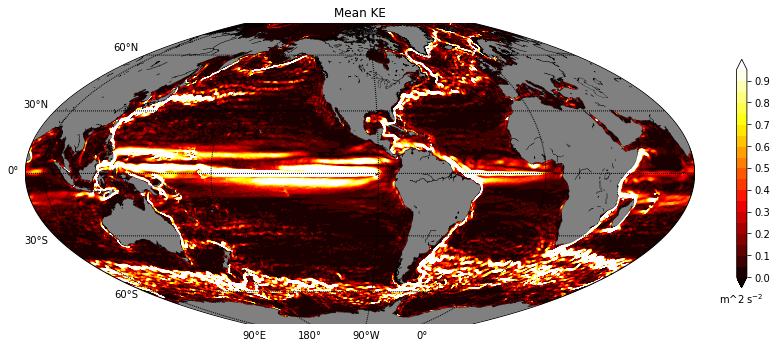

In [30]:
# Plot in basemap 

plt.figure(figsize=(15,6))
lev = np.arange(0, 1.0, 0.05)
map = Basemap(projection='mbtfpq',
              lon_0 = -100, resolution='l')
map.drawcoastlines(linewidth=0.25)
map.fillcontinents(color='gray',lake_color='gray')
map.drawparallels(np.arange(-60.,61.,30.),
                  labels=[True,False,False,False])
map.drawmeridians(np.arange(-180.,181.,90.),
                  labels=[False,False,False,True])

for box_index in tqdm_notebook(box_indexes):
    #print(box_index)
    dsx = calc_eke(expt, box_index)
    
    x=dsx.xu_ocean[:]
    y=dsx.yu_ocean[:]
    lon, lat = np.meshgrid(x, y)
    
    X, Y = map(lon,lat) 
    
    map.contourf(X, Y, dsx.MKE,
                 cmap=plt.cm.hot,
                 levels=lev,extend='both')

cb = plt.colorbar(orientation='vertical',shrink = 0.7)

cb.ax.set_xlabel('m^2 s$^{-2}$')
plt.title('Mean KE')